In [ ]:
# PREPROCESSING: normalize the input files (raw_data) to be between -1 and 1, because that's how TF works the best
# Try to train using GPU resource (if available)
# Talk about acceleration basing on our research with Pini
# Which model/architecture does Leonid expect as (ANN, CNN, etc.)
# Test different number of layers
# Try to correlate the different classification outputs to represent how similarity can have causality relationship with disimilarity
# Apply some manipulations to dataset so we can generate more samples, such as small shifts, pitch modulations, etc.

# Optimize Hardware performance - Throughput, #Mac operations, etc

In [5]:
# dependencies
! pip install pydub
! pip install tensorflow_io
! pip install tensorflow_datasets
! pip install tensorflow
! pip install tensorflow_io
! pip install pydub
! pip install tensorflow_datasets
! pip install tensorflow
!pip install scikit-learn
!pip install nnaudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 42.0 MB/s eta 0:00:00


In [8]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_io as tfio

In [9]:
version = 3 # just 3 is available
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
validation = ds['validation']
test = ds['test']
# tf.data.experimental.save(train, 'train_data')
# tf.data.experimental.save(validation, 'validation_data')
# tf.data.experimental.save(test, 'test_data')


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/85511 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.JMNGGT_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...:   0%|          | 0/10102 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.JMNGGT_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...:   0%|          | 0/4890 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.JMNGGT_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


In [ ]:
ds #random comment

{'train': <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'validation': <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [11]:
audio_list = []
for example in train.take(2):
    raw_audio = example['audio'].numpy()
    audio_list.append(raw_audio)
    numbered_label = example['label']
    # str_label = example['file']
    print(example)
    print()

{'audio': <tf.Tensor: shape=(16000,), dtype=int16, numpy=array([-15, -18, -12, ...,  16,  21,  25], dtype=int16)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=4>}

{'audio': <tf.Tensor: shape=(16000,), dtype=int16, numpy=array([  75,   29,  -85, ..., -343,  304,  879], dtype=int16)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=5>}



In [ ]:
# play audio
from IPython.display import Audio
for aud in audio_list:
  display(Audio(aud, rate=16000))

In [32]:
#load data set info
info = tfds.builder(f'speech_commands:0.0.{version}').info

In [33]:
info

tfds.core.DatasetInfo(
    name='speech_commands',
    full_name='speech_commands/0.0.3',
    description="""
    An audio dataset of spoken words designed to help train and evaluate keyword
    spotting systems. Its primary goal is to provide a way to build and test small
    models that detect when a single word is spoken, from a set of ten target words,
    with as few false positives as possible from background noise or unrelated
    speech. Note that in the train and validation set, the label "unknown" is much
    more prevalent than the labels of the target words or background noise. One
    difference from the release version is the handling of silent segments. While in
    the test set the silence segments are regular 1 second files, in the training
    they are provided as long segments under "background_noise" folder. Here we
    split these background noise into 1 second clips, and also keep one of the files
    for the validation set.
    """,
    homepage='https://arxiv.or

In [34]:
# get the list of labels
labels = info.features['label'].names
# get the number of labels
num_labels = info.features['label'].num_classes
# print the labels with their corresponding index
for i, label in enumerate(labels):
    print(f'{i}: {label}')

0: down
1: go
2: left
3: no
4: off
5: on
6: right
7: stop
8: up
9: yes
10: _silence_
11: _unknown_


In [35]:
# get the number of examples in the train, validation and test sets
num_train = info.splits['train'].num_examples
num_validation = info.splits['validation'].num_examples
num_test = info.splits['test'].num_examples
num_train, num_validation, num_test

(85511, 10102, 4890)

# baseline CNN

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio

# Constants
SAMPLE_RATE = 16000
DURATION = 1  # 1 second
NUM_MFCC = 13  # Number of MFCC features

# Function to preprocess audio
def preprocess_audio(audio):
    print("Original audio shape:", tf.shape(audio))
    # Convert audio to float32
    audio = tf.cast(audio, tf.float32) / 32768.0
    # audio = tf.squeeze(audio) # ensure the audio is 1-dimensional
    print("Audio shape after conversion to float32:", tf.shape(audio))

    # Trim the noise from the beginning and the end of the audio signal
    position = tfio.audio.trim(audio, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    audio = audio[start:stop]
    print("Audio shape after trimming:", tf.shape(audio))
    # Pad or truncate audio to 1 second
    # audio = tfio.audio.pad(audio, 0, SAMPLE_RATE - tf.shape(audio)[0])
    # audio = tfio.audio.crop(audio, 0, SAMPLE_RATE)
    audio = tf.pad(audio, paddings=[[0, SAMPLE_RATE - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    audio = tf.slice(audio, [0], [SAMPLE_RATE])
    print("Audio shape after padding/truncating:", tf.shape(audio))

    # Compute spectrogram
    spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=256)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=0, fmax=8000)

    # Convert to db scale
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    #convert to needed shape:
    # Transpose the mel-spectrogram to match the expected input shape
    dbscale_mel_spectrogram = tf.transpose(dbscale_mel_spectrogram)
    # Add a channel dimension
    dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=-1)
    print("Final audio shape: ", tf.shape(audio))
    print("return value shape: ", tf.shape(dbscale_mel_spectrogram))
    print("return value type: ", type(dbscale_mel_spectrogram))
    return dbscale_mel_spectrogram

# Function to preprocess dataset
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x: (preprocess_audio(x['audio']), x['label']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Preprocess datasets
train_preprocessed = preprocess_dataset(train)
validation_preprocessed = preprocess_dataset(validation)
test_preprocessed = preprocess_dataset(test)

# Batch and prefetch the datasets
BATCH_SIZE = 32

train_preprocessed = train_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

validation_preprocessed = validation_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_preprocessed = test_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)





Original audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape after conversion to float32: Tensor("Shape_1:0", shape=(1,), dtype=int32)
Audio shape after trimming: Tensor("Shape_3:0", shape=(1,), dtype=int32)
Audio shape after padding/truncating: Tensor("Shape_5:0", shape=(1,), dtype=int32)
Final audio shape:  Tensor("Shape_7:0", shape=(1,), dtype=int32)
return value shape:  Tensor("Shape_8:0", shape=(3,), dtype=int32)
return value type:  <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Original audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape after conversion to float32: Tensor("Shape_1:0", shape=(1,), dtype=int32)
Audio shape after trimming: Tensor("Shape_3:0", shape=(1,), dtype=int32)
Audio shape after padding/truncating: Tensor("Shape_5:0", shape=(1,), dtype=int32)
Final audio shape:  Tensor("Shape_7:0", shape=(1,), dtype=int32)
return value shape:  Tensor("Shape_8:0", shape=(3,), dtype=int32)
return value type:  <class 'tensorflow.python.f

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])
    return model

# Input shape
# input_shape = (128, 126, 1)  # Adjust based on the actual shape of your mel-spectrograms
input_shape = (128,63,1)

# Create and compile the model
model = create_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import numpy as np

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import os
import time
import tensorflow as tf

def benchmark_model(model, train_data, validation_data, test_data, model_name,drive_path = '/content/drive/MyDrive/Colab Notebooks/models/', epochs = 10):

    metrics = {}

    # Start timing for training
    start_time = time.time()

    # Training the model
    history = model.fit(train_data, validation_data=validation_data, epochs=epochs)

    # Calculate training time
    total_time = time.time() - start_time
    metrics['Training Time (seconds)'] = total_time
    print(f"Training Time: {total_time:.2f} seconds")

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_data)
    metrics['Test Accuracy (%)'] = test_accuracy * 100
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Make predictions on test data
    y_pred = np.argmax(model.predict(test_data), axis=-1)
    y_true = np.concatenate([y for x, y in test_data], axis=0)

    # Compute F1 Score, Precision, Recall, and Confusion Matrix
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    metrics['F1 Score'] = f1
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['Confusion Matrix'] = conf_matrix

    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # Model size (in MB)
    model_path = os.path.join(drive_path, f'{model_name}_epochs{epochs}.h5')
    model.save(model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    metrics['Model Size (MB)'] = model_size
    print(f'Model Size: {model_size:.2f} MB')

    # Number of parameters
    total_params = model.count_params()
    trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    metrics['Total Parameters'] = total_params
    metrics['Trainable Parameters'] = trainable_params
    metrics['Non-trainable Parameters'] = non_trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-trainable Parameters: {non_trainable_params}")

    return metrics


In [20]:
benchmark_model(model,train_preprocessed,validation_preprocessed,test_preprocessed, "ClassicCNN")

Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9360 - loss: 0.2048 - val_accuracy: 0.9141 - val_loss: 0.3288
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9406 - loss: 0.1933 - val_accuracy: 0.9148 - val_loss: 0.3500
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9408 - loss: 0.1941 - val_accuracy: 0.9167 - val_loss: 0.3467
Epoch 4/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9442 - loss: 0.1784 - val_accuracy: 0.9210 - val_loss: 0.3884
Epoch 5/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9458 - loss: 0.1728 - val_accuracy: 0.9190 - val_loss: 0.3781
Epoch 6/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9480 - loss: 0.1655 - val_accuracy: 0.9205 - val_loss: 0.3718
Epoch 7/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9514 - loss: 0.1563 - val_accuracy: 0.9182 - val_loss: 0.3813
Epoch 8/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9509 - loss: 0

F1 Score: 0.83
Precision: 0.90
Recall: 0.80
Confusion Matrix:
[[322   3   0  15   0   1   0   1   0   2   0  62]
 [  4 303   0  20   3   0   0   1   0   0   0  71]
 [  0   0 345   0   1   0   1   0   0   7   0  58]
 [  5  20   1 337   0   0   0   0   0   0   0  42]
 [  0   0   1   0 327   5   0   0  18   0   0  51]
 [  0   0   0   0  20 299   0   0   1   0   0  76]
 [  0   0   2   0   0   0 322   0   0   0   0  72]
 [  2   2   0   0   2   0   0 324  10   0   0  71]
 [  0   0   0   1  10   1   0   4 342   0   0  67]
 [  1   1   2   0   0   0   0   0   0 383   0  32]
 [  0   0   0   0   1   0   0   0   0   0 232 175]
 [  0   2   3   1   1   1   1   0   2   0   0 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       406
           1       0.92      0.75      0.83       402
           2       0.97      0.84      0.90       412
           3       0.90      0.83      0.87       405
           4       0.90      0.

{'Training Time (seconds)': 154.37893557548523,
 'Test Accuracy (%)': 80.42944669723511,
 'F1 Score': 0.830484203700637,
 'Precision': 0.9026186067977109,
 'Recall': 0.8042944785276074,
 'Confusion Matrix': array([[322,   3,   0,  15,   0,   1,   0,   1,   0,   2,   0,  62],
        [  4, 303,   0,  20,   3,   0,   0,   1,   0,   0,   0,  71],
        [  0,   0, 345,   0,   1,   0,   1,   0,   0,   7,   0,  58],
        [  5,  20,   1, 337,   0,   0,   0,   0,   0,   0,   0,  42],
        [  0,   0,   1,   0, 327,   5,   0,   0,  18,   0,   0,  51],
        [  0,   0,   0,   0,  20, 299,   0,   0,   1,   0,   0,  76],
        [  0,   0,   2,   0,   0,   0, 322,   0,   0,   0,   0,  72],
        [  2,   2,   0,   0,   2,   0,   0, 324,  10,   0,   0,  71],
        [  0,   0,   0,   1,  10,   1,   0,   4, 342,   0,   0,  67],
        [  1,   1,   2,   0,   0,   0,   0,   0,   0, 383,   0,  32],
        [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0, 232, 175],
        [  0,   2,   3, 

In [11]:
# Training the model
import os

drive_path = '/content/drive/MyDrive/Colab Notebooks/models/'  # Adjust the path as needed
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

EPOCHS = [10]
path = r"C:\Users\User\Desktop\Computer Eng\Advanced Computer Architecture"
for ep in EPOCHS:
  print(f'Training for {ep} epochs')
  history = model.fit(train_preprocessed, validation_data=validation_preprocessed, epochs=ep)
  test_loss, test_accuracy = model.evaluate(test_preprocessed)
  print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
  # Make predictions on the test set
  y_pred = np.argmax(model.predict(test_preprocessed), axis=-1)
  y_true = np.concatenate([y for x, y in test_preprocessed], axis=0)

  # Calculate F1 score and confusion matrix
  f1 = f1_score(y_true, y_pred, average='weighted')
  conf_matrix = confusion_matrix(y_true, y_pred)

  print(f'F1 Score: {f1:.2f}')
  print('Confusion Matrix:')
  print(conf_matrix)
  print('Classification Report:')
  print(classification_report(y_true, y_pred))

  model.save(os.path.join(drive_path, f'kws_cnn_model_ephocs{ep}.h5'))





Training for 10 epochs
Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 105s 39ms/step - accuracy: 0.8741 - loss: 0.3996 - val_accuracy: 0.8892 - val_loss: 0.3462
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 103s 39ms/step - accuracy: 0.8869 - loss: 0.3614 - val_accuracy: 0.8989 - val_loss: 0.3420
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 101s 38ms/step - accuracy: 0.8967 - loss: 0.3260 - val_accuracy: 0.8945 - val_loss: 0.3442
Epoch 4/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 142s 38ms/step - accuracy: 0.9073 - loss: 0.2976 - val_accuracy: 0.8895 - val_loss: 0.3890
Epoch 5/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 104s 39ms/step - accuracy: 0.9148 - loss: 0.2730 - val_accuracy: 0.9105 - val_loss: 0.3214
Epoch 6/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 137s 37ms/step - accuracy: 0.9199 - loss: 0.2514 - val_accuracy: 0.9125 - val_loss: 0.3080
Epoch 7/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 102s 38ms/step - accuracy: 0.9248 - loss: 0.2360 - val_accuracy: 0.9176 - val_loss: 0.3454
Epoch 8/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 153s

F1 Score: 0.83
Confusion Matrix:
[[313   7   0  16   0   1   0   4   0   2   0  63]
 [  5 322   0  11   0   0   0   3   1   0   0  60]
 [  1   0 335   0   0   0   0   0   0   4   0  72]
 [  7  31   2 322   1   0   0   0   0   0   0  42]
 [  0   1   0   0 319   6   0   1  18   0   0  57]
 [  0   0   0   0  15 329   0   0   0   0   0  52]
 [  0   0   3   0   0   0 312   0   0   0   0  81]
 [  1   5   0   0   1   0   0 333   7   0   0  64]
 [  0   0   1   0  15   4   0  10 326   0   0  69]
 [  0   0   2   0   0   0   0   0   0 388   0  29]
 [  0   0   0   0   0   0   0   0   0   0 230 178]
 [  0   3   1   3   2   2   1   0   0   0   0 396]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       406
           1       0.87      0.80      0.84       402
           2       0.97      0.81      0.89       412
           3       0.91      0.80      0.85       405
           4       0.90      0.79      0.85       402
      

In [ ]:
test_loss, test_accuracy = model.evaluate(test_preprocessed)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
# Make predictions on the test set
y_pred = np.argmax(model.predict(test_preprocessed), axis=-1)
y_true = np.concatenate([y for x, y in test_preprocessed], axis=0)

# Calculate F1 score and confusion matrix
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'F1 Score: {f1:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_true, y_pred))

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_preprocessed)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8000 - loss: 1.1544
Test Accuracy: 80.43%


# 1D CNN

In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import os
import time
import tensorflow as tf

def benchmark_model_1d(model, train_data, validation_data, test_data, model_name,callback, drive_path = '/content/drive/MyDrive/Colab Notebooks/models/', epochs = 10):

    metrics = {}

    # Start timing for training
    start_time = time.time()

    # Training the model
    history = model.fit(train_data, validation_data=validation_data, epochs=epochs,callback = [callback])

    # Calculate training time
    total_time = time.time() - start_time
    metrics['Training Time (seconds)'] = total_time
    print(f"Training Time: {total_time:.2f} seconds")

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_data)
    metrics['Test Accuracy (%)'] = test_accuracy * 100
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Make predictions on test data
    y_pred = np.argmax(model.predict(test_data), axis=-1)
    y_true = np.concatenate([y for x, y in test_data], axis=0)

    # Compute F1 Score, Precision, Recall, and Confusion Matrix
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    metrics['F1 Score'] = f1
    metrics['Precision'] = precision
    metrics['Recall'] = recall
    metrics['Confusion Matrix'] = conf_matrix

    print(f'F1 Score: {f1:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(classification_report(y_true, y_pred))

    # Model size (in MB)
    model_path = os.path.join(drive_path, f'{model_name}_epochs{epochs}.h5')
    model.save(model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
    metrics['Model Size (MB)'] = model_size
    print(f'Model Size: {model_size:.2f} MB')

    # Number of parameters
    total_params = model.count_params()
    trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
    non_trainable_params = total_params - trainable_params

    metrics['Total Parameters'] = total_params
    metrics['Trainable Parameters'] = trainable_params
    metrics['Non-trainable Parameters'] = non_trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-trainable Parameters: {non_trainable_params}")

    return metrics


In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio

# Constants
SAMPLE_RATE = 16000
DURATION = 1  # 1 second
NUM_MFCC = 13  # Number of MFCC features

# Function to preprocess audio
def preprocess_audio(audio):
    # Convert audio to float32
    audio = tf.cast(audio, tf.float32) / 32768.0
    # audio = tf.squeeze(audio) # ensure the audio is 1-dimensional
    print(tf.shape(audio))

    # Trim the noise from the beginning and the end of the audio signal
    position = tfio.audio.trim(audio, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    audio = audio[start:stop]

    # Pad or truncate audio to 1 second
    # audio = tfio.audio.pad(audio, 0, SAMPLE_RATE - tf.shape(audio)[0])
    # audio = tfio.audio.crop(audio, 0, SAMPLE_RATE)
    audio = tf.pad(audio, paddings=[[0, SAMPLE_RATE - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    audio = tf.slice(audio, [0], [SAMPLE_RATE])

    # only in 2d:
    # Compute spectrogram
    # spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=256)

    # Convert to mel-spectrogram
    # mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=0, fmax=8000)

    # Convert to db scale
    # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    #convert to needed shape:
    # Transpose the mel-spectrogram to match the expected input shape
    # dbscale_mel_spectrogram = tf.transpose(dbscale_mel_spectrogram)
    # Add a channel dimension
    # dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=-1)

    # in 1d:
    audio = tf.expand_dims(audio, axis=-1)  # Shape will be (16000, 1)


    return audio

# Function to preprocess dataset
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x: (preprocess_audio(x['audio']), x['label']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Preprocess datasets
train_preprocess = preprocess_dataset(ds['train'])
validation_preprocess = preprocess_dataset(ds['validation'])
test_preprocess = preprocess_dataset(ds['test'])

# Batch and prefetch the datasets
BATCH_SIZE = 32

train_preprocess = train_preprocess.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_preprocess = validation_preprocess.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_preprocess = test_preprocess.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)



Tensor("Shape:0", shape=(1,), dtype=int32)
Tensor("Shape:0", shape=(1,), dtype=int32)
Tensor("Shape:0", shape=(1,), dtype=int32)


In [49]:
'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])
    return model
'''
# Define the model for 1D Convolution
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_model(input_shape):
    model = Sequential([
        Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),

        Conv1D(64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),

        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),

        Conv1D(256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])
    return model


# Input shape
# input_shape = (128, 126, 1)  # Adjust based on the actual shape of your mel-spectrograms
# input_shape = (128,63,1)
# Input shape for 1D convolution

input_shape = (16000, 1)  # (16000, 1)

# Create and compile the model
model = create_model(input_shape)
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# Training the model
import os

drive_path = '/content/drive/MyDrive/Colab Notebooks/models/'  # Adjust the path as needed
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

EPOCHS = [3,5,10]
path = r"C:\Users\User\Desktop\Computer Eng\Advanced Computer Architecture"
for ep in EPOCHS:
  print(f'Training for {ep} epochs')
  history = model.fit(train, validation_data=validation, epochs=ep, callbacks=[callback])
  test_loss, test_accuracy = model.evaluate(test)
  print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
  # Make predictions on the test set
  y_pred = np.argmax(model.predict(test), axis=-1)
  y_true = np.concatenate([y for x, y in test], axis=0)

  # Calculate F1 score and confusion matrix
  f1 = f1_score(y_true, y_pred, average='weighted')
  conf_matrix = confusion_matrix(y_true, y_pred)

  print(f'F1 Score: {f1:.2f}')
  print('Confusion Matrix:')
  print(conf_matrix)
  print('Classification Report:')
  print(classification_report(y_true, y_pred))

  model.save(os.path.join(drive_path, f'kws_cnn_model_ephocs{ep}.h5'))





Training for 3 epochs
Epoch 1/3


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_6_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 16000, 1), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs={'audio': 'tf.Tensor(shape=(None,), dtype=int16)', 'label': 'tf.Tensor(shape=(), dtype=int64)'}
  • training=True
  • mask={'audio': 'None', 'label': 'None'}

# Let's experiment with nnaudio preprocessing

In [14]:
# prompt: check nnaudio package version from terminal

!pip show nnaudio


In [16]:
import nnAudio as nn
from nnAudio.features import MelSpectrogram

Object `nn.features` not found.


In [ ]:
train = ds['train']
validation = ds['validation']
test = ds['test']

In [ ]:
train

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [ ]:
tf.print(ds['train'])

<_PrefetchDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int16, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
ds, info = tfds.load('speech_commands', split=['train', 'validation', 'test'], as_supervised=False, with_info=True)

# Function to check dataset shape
def check_dataset_shape(dataset, dataset_name):
    num_samples = tf.data.experimental.cardinality(dataset).numpy()
    print(f"{dataset_name} dataset contains {num_samples} samples.")
    for example in dataset.take(1):  # Taking only one example to check the shape
        audio = example['audio']
        label = example['label']
        tf.print(f"\n{dataset_name} Dataset")
        tf.print("Audio shape:", tf.shape(audio))
        tf.print("Label shape:", tf.shape(label))
        tf.print("Label value:", label)

# Check the shape of the 'train', 'validation', and 'test' datasets
check_dataset_shape(train, "Train")
check_dataset_shape(validation, "Validation")
check_dataset_shape(test, "Test")


Train dataset contains 85511 samples.

Train Dataset
Audio shape: [16000]
Label shape: []
Label value: 4
Validation dataset contains 10102 samples.

Validation Dataset
Audio shape: [16000]
Label shape: []
Label value: 3
Test dataset contains 4890 samples.

Test Dataset
Audio shape: [16000]
Label shape: []
Label value: 7


In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import torch
from nnAudio.features import MelSpectrogram
import numpy as np

# Constants
SAMPLE_RATE = 16000
EXPECTED_SHAPE = (128, 63)  # This should match the expected input shape of the CNN

# Function to preprocess audio using nnAudio
def preprocess_audio_nnaudio(audio):
    # Print the shape of the original audio
    print("Original audio shape:", tf.shape(audio))

    # Convert audio to float32
    audio = tf.cast(audio, tf.float32) / 32768.0
    print("Audio shape after conversion to float32:", tf.shape(audio))

    # Trim the noise from the beginning and the end of the audio signal
    position = tfio.audio.trim(audio, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    audio = audio[start:stop]
    print("Audio shape after trimming:", tf.shape(audio))

    # Pad or truncate audio to 1 second
    audio = tf.pad(audio, paddings=[[0, SAMPLE_RATE - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    audio = tf.slice(audio, [0], [SAMPLE_RATE])
    print("Audio shape after padding/truncating:", tf.shape(audio))

    # Function to compute Mel-spectrogram using nnAudio
    def compute_mel_spectrogram(audio_np):
        # Convert NumPy array to PyTorch tensor
        audio_pt = torch.tensor(audio_np, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

        # Use nnAudio's MelSpectrogram
        mel_spec = MelSpectrogram(sr=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=128, fmin=0, fmax=8000)
        mel_spectrogram = mel_spec(audio_pt)

        # Convert to dB scale (log scale)
        db_mel_spectrogram = torch.log10(mel_spectrogram + 1e-6)

        # Squeeze to remove batch dimension and convert back to NumPy
        return db_mel_spectrogram.squeeze(0).cpu().numpy()

    # Use tf.py_function to handle NumPy conversion and integrate nnAudio processing
    db_mel_spectrogram = tf.py_function(
        func=compute_mel_spectrogram,
        inp=[audio],  # Pass TensorFlow tensor, TensorFlow will handle conversion
        Tout=tf.float32
    )

    # Print shape after nnAudio processing (should be [128, 63])
    print("Mel-spectrogram shape after nnAudio processing:", tf.shape(db_mel_spectrogram))

    # Set the correct shape for the tensor
    db_mel_spectrogram.set_shape(EXPECTED_SHAPE)

    # Add a channel dimension
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, axis=-1)
    print("Final mel-spectrogram type:", type(db_mel_spectrogram))
    print("Final mel-spectrogram shape:", tf.shape(db_mel_spectrogram))

    return db_mel_spectrogram

# Function to preprocess dataset with nnAudio
def preprocess_dataset_nnaudio(dataset):
    dataset = dataset.map(lambda x: (preprocess_audio_nnaudio(x['audio']), x['label']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


# Preprocess datasets using nnAudio
train_preprocessed_nn = preprocess_dataset_nnaudio(train)
validation_preprocessed_nn = preprocess_dataset_nnaudio(validation)
test_preprocessed_nn = preprocess_dataset_nnaudio(test)

# Batch and prefetch the datasets
BATCH_SIZE = 32
train_preprocessed_nn = train_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_preprocessed_nn = validation_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_preprocessed_nn = test_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


Original audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape after conversion to float32: Tensor("Shape_1:0", shape=(1,), dtype=int32)
Audio shape after trimming: Tensor("Shape_3:0", shape=(1,), dtype=int32)
Audio shape after padding/truncating: Tensor("Shape_5:0", shape=(1,), dtype=int32)
Mel-spectrogram shape after nnAudio processing: Tensor("Shape_6:0", shape=(None,), dtype=int32)
Final mel-spectrogram type: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
Final mel-spectrogram shape: Tensor("Shape_7:0", shape=(3,), dtype=int32)
Original audio shape: Tensor("Shape:0", shape=(1,), dtype=int32)
Audio shape after conversion to float32: Tensor("Shape_1:0", shape=(1,), dtype=int32)
Audio shape after trimming: Tensor("Shape_3:0", shape=(1,), dtype=int32)
Audio shape after padding/truncating: Tensor("Shape_5:0", shape=(1,), dtype=int32)
Mel-spectrogram shape after nnAudio processing: Tensor("Shape_6:0", shape=(None,), dtype=int32)
Final mel-spectrogram type: <class 

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])
    return model

# Input shape
# input_shape = (128, 126, 1)  # Adjust based on the actual shape of your mel-spectrograms
input_shape = (128,63,1)

# Create and compile the model
model = create_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
benchmark_model(model,train_preprocessed_nn,validation_preprocessed_nn,test_preprocessed_nn, "ClassicCNN+nnAudioPreProcessing")

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filehhkaurpr.py", line 27, in compute_mel_spectrogram
    audio_pt = ag__.converted_call(ag__.converted_call(ag__.ld(torch).tensor, (ag__.ld(audio_np),), dict(dtype=ag__.ld(torch).float32), fscope_1).unsqueeze, (0,), None, fscope_1)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 349, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_filehhkaurpr.py", line 27, in compute_mel_spectrogram
    audio_pt = ag__.converted_call(ag__.converted_call(ag__.ld(torch).tensor, (ag__.ld(audio_np),), dict(dtype=ag__.ld(torch).float32), fscope_1).unsqueeze, (0,), None, fscope_1)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 349, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_217568]

In [ ]:
# Training the model
import os

drive_path = '/content/drive/MyDrive/Colab Notebooks/models/'  # Adjust the path as needed
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

EPOCHS = [3,5,10]
path = r"C:\Users\User\Desktop\Computer Eng\Advanced Computer Architecture"
for ep in EPOCHS:
  print(f'Training for {ep} epochs')
  history = model.fit(train_preprocessed_nn, validation_data=validation_preprocessed_nn, epochs=ep)
  test_loss, test_accuracy = model.evaluate(test_preprocessed_nn)
  print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
  # Make predictions on the test set
  y_pred = np.argmax(model.predict(test_preprocessed_nn), axis=-1)
  y_true = np.concatenate([y for x, y in test_preprocessed_nn], axis=0)

  # Calculate F1 score and confusion matrix
  f1 = f1_score(y_true, y_pred, average='weighted')
  conf_matrix = confusion_matrix(y_true, y_pred)

  print(f'F1 Score: {f1:.2f}')
  print('Confusion Matrix:')
  print(conf_matrix)
  print('Classification Report:')
  print(classification_report(y_true, y_pred))

  model.save(os.path.join(drive_path, f'kws_cnn_model_ephocs{ep}.h5'))





Training for 3 epochs
Epoch 1/3


InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_fileem1phc7x.py", line 27, in compute_mel_spectrogram
    audio_pt = ag__.converted_call(ag__.converted_call(ag__.ld(torch).tensor, (ag__.ld(audio_np),), dict(dtype=ag__.ld(torch).float32), fscope_1).unsqueeze, (0,), None, fscope_1)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 349, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:  TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/tmp/__autograph_generated_fileem1phc7x.py", line 27, in compute_mel_spectrogram
    audio_pt = ag__.converted_call(ag__.converted_call(ag__.ld(torch).tensor, (ag__.ld(audio_np),), dict(dtype=ag__.ld(torch).float32), fscope_1).unsqueeze, (0,), None, fscope_1)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 459, in _call_unconverted
    return f(*args, **kwargs)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 349, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_one_step_on_iterator_113143]

# nnAudio test

In [28]:
import tensorflow as tf
import tensorflow_io as tfio
import torch
from nnAudio.features import MelSpectrogram
import numpy as np
import logging


# Constants
SAMPLE_RATE = 16000
EXPECTED_SHAPE = (128, 63)  # Expected input shape for CNN

# Function to preprocess audio using nnAudio
def preprocess_audio_nnaudio(audio):
    # Print the shape of the original audio
    # tf.print("Original audio shape:", tf.shape(audio))

    # Convert audio to float32
    audio = tf.cast(audio, tf.float32) / 32768.0
    # tf.print("Audio shape after conversion to float32:", tf.shape(audio))

    # Trim the noise from the beginning and the end of the audio signal
    position = tfio.audio.trim(audio, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    audio = audio[start:stop]
    # tf.print("Audio shape after trimming:", tf.shape(audio))

    # Pad or truncate audio to 1 second
    audio = tf.pad(audio, paddings=[[0, SAMPLE_RATE - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    audio = tf.slice(audio, [0], [SAMPLE_RATE])
    # tf.print("Audio shape after padding/truncating:", tf.shape(audio))

    # Ensure audio is a valid tensor with 1D shape before passing to PyTorch
    audio = tf.ensure_shape(audio, [SAMPLE_RATE])
    # tf.print("Audio shape before passing to PyTorch (final check):", tf.shape(audio))

    # Function to compute Mel-spectrogram using nnAudio
    def compute_mel_spectrogram(audio_tensor):
        # Convert the TensorFlow tensor to a NumPy array (force eager execution)
        audio_np = audio_tensor.numpy()  # Ensure conversion to NumPy array

        # Check if audio_np is a valid NumPy array
        # if isinstance(audio_np, np.ndarray):
            # print(f"Received NumPy array with shape: {audio_np.shape}")
        # else:
            # raise ValueError(f"Expected a NumPy array, but got {type(audio_np)}")

        # Convert NumPy array to PyTorch tensor
        audio_pt = torch.tensor(audio_np, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

        # Use nnAudio's MelSpectrogram
        mel_spec = MelSpectrogram(sr=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=128, fmin=0, fmax=8000,verbose = False)
        mel_spectrogram = mel_spec(audio_pt)

        # Convert to dB scale (log scale)
        db_mel_spectrogram = torch.log10(mel_spectrogram + 1e-6)

        # Convert to NumPy array after processing
        return db_mel_spectrogram.squeeze(0).cpu().numpy()

    # Use tf.py_function to handle NumPy conversion and integrate nnAudio processing
    db_mel_spectrogram = tf.py_function(
        func=compute_mel_spectrogram,
        inp=[audio],  # Pass TensorFlow tensor, convert to NumPy in compute_mel_spectrogram
        Tout=tf.float32
    )

    # Explicitly set the shape for the tensor after processing
    db_mel_spectrogram.set_shape(EXPECTED_SHAPE)

    # Print shape after setting it explicitly
    # tf.print("Mel-spectrogram shape after setting the shape:", tf.shape(db_mel_spectrogram))

    # Add a channel dimension
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, axis=-1)
    # tf.print("Final mel-spectrogram shape:", tf.shape(db_mel_spectrogram))

    return db_mel_spectrogram

# Function to preprocess dataset with nnAudio
def preprocess_dataset_nnaudio(dataset):
    dataset = dataset.map(lambda x: (preprocess_audio_nnaudio(x['audio']), x['label']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Load datasets

# Preprocess datasets using nnAudio
train_preprocessed_nn = preprocess_dataset_nnaudio(train).cache()
validation_preprocessed_nn = preprocess_dataset_nnaudio(validation).cache()
test_preprocessed_nn = preprocess_dataset_nnaudio(test).cache()

# Batch and prefetch the datasets
BATCH_SIZE = 32
train_preprocessed_nn = train_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_preprocessed_nn = validation_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_preprocessed_nn = test_preprocessed_nn.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Model definition




In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')
    ])
    return model

# Input shape based on Mel-spectrograms
input_shape = (128, 63, 1)

# Create and compile the model
model = create_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
benchmark_model(model,train_preprocessed_nn,validation_preprocessed_nn,test_preprocessed_nn, "ClassicCNN+nnAudioPreProcessing")

Epoch 1/10
  10/2673 ━━━━━━━━━━━━━━━━━━━━ 39:49 897ms/step - accuracy: 0.3522 - loss: 4.8099

KeyboardInterrupt: 

# nnaudio FINAL

In [ ]:
!pip install tqdm


In [ ]:
train

NameError: name 'train' is not defined

In [ ]:
!pip install nnAudio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00


In [61]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import nnAudio
import tensorflow as tf
import tensorflow_datasets as tfds
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from nnAudio.features import MelSpectrogram
import time
import matplotlib.pyplot as plt

# Define constants
SAMPLE_RATE = 16000
DESIRED_LENGTH = 16000
BATCH_SIZE = 32
EPOCHS = 10  # Change based on your training needs
NUM_CLASSES = 12

# Preprocessing function for TensorFlow
def preprocess_audio(audio):
    waveform = audio['audio']
    label = audio['label']
    waveform = tf.squeeze(waveform)
    waveform = tf.cast(waveform, tf.float32) / tf.int16.max
    # Pad or truncate the waveform to the desired length
    waveform = tf.cond(
        tf.shape(waveform)[0] < DESIRED_LENGTH,
        lambda: tf.pad(waveform, [[0, DESIRED_LENGTH - tf.shape(waveform)[0]]]),
        lambda: waveform[:DESIRED_LENGTH]
    )
    return waveform, label

# Apply preprocessing to datasets
ds_train = train.map(preprocess_audio)
ds_test = test.map(preprocess_audio)

# Batch and prefetch the datasets
ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom IterableDataset class to load data lazily from TensorFlow to PyTorch
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset

    def __iter__(self):
        for waveform, label in self.tf_dataset:
            waveform = torch.tensor(waveform.numpy())
            label = torch.tensor(label.numpy())
            yield waveform, label

    def __len__(self):
        return tf.data.experimental.cardinality(self.tf_dataset).numpy()

# Create PyTorch-compatible DataLoaders with IterableDataset
train_loader = DataLoader(TFDatasetToTorch(ds_train), batch_size=None)  # Batch size is handled by TensorFlow
test_loader = DataLoader(TFDatasetToTorch(ds_test), batch_size=None)

# Define the PyTorch model
class KWSModel(nn.Module):
    def __init__(self):
        super(KWSModel, self).__init__()
        self.mel_spectrogram = MelSpectrogram(n_mels=128, sr=SAMPLE_RATE, n_fft=1024, hop_length=512, verbose=False)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(64 * 128 * 32, 128)  # Adjust input size for your data
        self.fc2 = nn.Linear(128, NUM_CLASSES)  # Assuming 12 classes

    def forward(self, x):
        x = self.mel_spectrogram(x)
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define evaluation function for metrics
def evaluate_model(model, test_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, avg_loss, precision, recall, f1, conf_matrix

# Function to calculate model size in MB
def get_model_size(model, model_path):
    torch.save(model.state_dict(), model_path)
    size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove(model_path)
    return size

# Calculate total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Initialize model, criterion, and optimizer
model = KWSModel().to(device)  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start timing for training
start_time = time.time()

# Training loop
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=f'{running_loss / (len(train_loader)):.4f}')
            pbar.update(1)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss / len(train_loader):.4f}')

# Training time
total_training_time = time.time() - start_time
print(f"Training Time: {total_training_time:.2f} seconds")

# Final evaluation on test data
accuracy, avg_loss, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader, criterion)

# Save the model and calculate its size
model_path = "kws_model_nnaudio.pth"
model_size = get_model_size(model, model_path)
print(f"Model Size: {model_size:.2f} MB")

# Count total and trainable parameters
total_params, trainable_params = count_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Epoch 1/10: 100%|██████████| 2673/2673 [00:23<00:00, 112.44batch/s, loss=1.1828]


Epoch [1/10], Loss: 1.1828


Epoch 2/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.45batch/s, loss=0.7732]


Epoch [2/10], Loss: 0.7732


Epoch 3/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.76batch/s, loss=0.6142]


Epoch [3/10], Loss: 0.6142


Epoch 4/10: 100%|██████████| 2673/2673 [00:23<00:00, 114.56batch/s, loss=0.5143]


Epoch [4/10], Loss: 0.5143


Epoch 5/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.13batch/s, loss=0.4322]


Epoch [5/10], Loss: 0.4322


Epoch 6/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.52batch/s, loss=0.3655]


Epoch [6/10], Loss: 0.3655


Epoch 7/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.30batch/s, loss=0.3097]


Epoch [7/10], Loss: 0.3097


Epoch 8/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.24batch/s, loss=0.2631]


Epoch [8/10], Loss: 0.2631


Epoch 9/10: 100%|██████████| 2673/2673 [00:23<00:00, 114.47batch/s, loss=0.2279]


Epoch [9/10], Loss: 0.2279


Epoch 10/10: 100%|██████████| 2673/2673 [00:23<00:00, 113.25batch/s, loss=0.2044]


Epoch [10/10], Loss: 0.2044
Training Time: 235.54 seconds
Accuracy: 57.55%
F1 Score: 0.61
Precision: 0.74
Recall: 0.58
Confusion Matrix:
[[203  11   0  30   0   1   1   4   0   3   0 153]
 [ 21 170   2  68   6   1   2   4   4   3   0 121]
 [  2   0 208   4   4   0  12   2  16  42   0 122]
 [ 21  51   3 180   0   2   3   5   6   1   0 133]
 [  1   5   4   3 236   1   1   7  37   5   0 102]
 [  6   0   0   3  16 148   2   0   3   0   0 218]
 [  2   0  18   0   1   3 212   0   5   0   0 155]
 [  4   5   1   5  11   2   0 239  34   1   0 109]
 [  1   5  17   7  25   1   2  12 241   3   0 111]
 [  0   0  24   0   0   1   1   1   3 312   0  77]
 [  0   0   2   1   2   0   0   4   3   0 304  92]
 [  6   4   6   3   4   9   5   2   5   3   0 361]]
Model Size: 132.34 MB
Total Parameters: 33574924
Trainable Parameters: 33574924


# Trying out a resnet

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_io as tfio
import tensorflow_datasets as tfds

# Constants
SAMPLE_RATE = 16000
EXPECTED_SHAPE = (128, 63, 1)  # Expected input shape for ResNet (same as before)

# Function to preprocess audio using TensorFlow IO
def preprocess_audio(audio):
    # Convert audio to float32
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Trim the noise from the beginning and the end of the audio signal
    position = tfio.audio.trim(audio, axis=0, epsilon=0.05)
    start = position[0]
    stop = position[1]
    audio = audio[start:stop]

    # Pad or truncate audio to 1 second
    audio = tf.pad(audio, paddings=[[0, SAMPLE_RATE - tf.shape(audio)[0]]], mode='CONSTANT', constant_values=0)
    audio = tf.slice(audio, [0], [SAMPLE_RATE])

    # Compute spectrogram
    spectrogram = tfio.audio.spectrogram(audio, nfft=512, window=512, stride=256)

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=0, fmax=8000)

    # Convert to dB scale
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Transpose and expand dimensions to match the expected ResNet input shape
    dbscale_mel_spectrogram = tf.transpose(dbscale_mel_spectrogram)
    dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=-1)

    return dbscale_mel_spectrogram

# Function to preprocess dataset
def preprocess_dataset(dataset):
    dataset = dataset.map(lambda x: (preprocess_audio(x['audio']), x['label']), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset


# Preprocess datasets
train_preprocessed = preprocess_dataset(train)
validation_preprocessed = preprocess_dataset(validation)
test_preprocessed = preprocess_dataset(test)

# Batch and prefetch the datasets
BATCH_SIZE = 32
train_preprocessed = train_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_preprocessed = validation_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_preprocessed = test_preprocessed.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define a simple ResNet-like model
def resnet_block(input_tensor, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same', use_bias=False)(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_resnet(input_shape, num_classes=12):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 256, strides=2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Input shape based on Mel-spectrograms
input_shape = (128, 63, 1)

# Create and compile the ResNet model
model = create_resnet(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

'''
# Training the ResNet model
EPOCHS = 10
history = model.fit(train_preprocessed, validation_data=validation_preprocessed, epochs=EPOCHS)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_preprocessed)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
'''
benchmark_model(model,train_preprocessed,validation_preprocessed,test_preprocessed, "ClassicResNet")

Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.6862 - loss: 1.1279 - val_accuracy: 0.8109 - val_loss: 0.5667
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.8655 - loss: 0.4196 - val_accuracy: 0.8763 - val_loss: 0.3885
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9024 - loss: 0.3128 - val_accuracy: 0.8257 - val_loss: 0.5338
Epoch 4/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9197 - loss: 0.2512 - val_accuracy: 0.8925 - val_loss: 0.3779
Epoch 5/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9340 - loss: 0.2115 - val_accuracy: 0.9025 - val_loss: 0.3188
Epoch 6/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9428 - loss: 0.1777 - val_accuracy: 0.9135 - val_loss: 0.2898
Epoch 7/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9503 - loss: 0.1553 - val_accuracy: 0.9210 - val_loss: 0.3061
Epoch 8/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9559 - loss: 

F1 Score: 0.86
Precision: 0.91
Recall: 0.85
Confusion Matrix:
[[311   4   0  24   0   0   0   6   0   3   0  58]
 [  1 324   1  29   0   0   0   1   1   2   0  43]
 [  0   0 372   0   0   0   7   0   0   3   0  30]
 [  4   6   4 367   0   0   0   0   2   0   0  22]
 [  0   4   1   1 349   4   0   1  13   0   0  29]
 [  0   0   0   0  27 318   0   0   2   0   0  49]
 [  0   0   1   0   0   0 365   0   0   0   0  30]
 [  7   6   0   2   0   0   0 339  10   0   0  47]
 [  0   0   0   0  13   0   0   2 353   0   0  57]
 [  0   0   4   0   0   0   0   0   0 395   0  20]
 [  0   0   0   0   0   0   0   0   0   0 246 162]
 [  0   2   0   2   1   3   3   1   1   1   0 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       406
           1       0.94      0.81      0.87       402
           2       0.97      0.90      0.94       412
           3       0.86      0.91      0.88       405
           4       0.89      0.

{'Training Time (seconds)': 212.9408769607544,
 'Test Accuracy (%)': 84.51942801475525,
 'F1 Score': 0.8593827365292133,
 'Precision': 0.9057703049137545,
 'Recall': 0.8451942740286299,
 'Confusion Matrix': array([[311,   4,   0,  24,   0,   0,   0,   6,   0,   3,   0,  58],
        [  1, 324,   1,  29,   0,   0,   0,   1,   1,   2,   0,  43],
        [  0,   0, 372,   0,   0,   0,   7,   0,   0,   3,   0,  30],
        [  4,   6,   4, 367,   0,   0,   0,   0,   2,   0,   0,  22],
        [  0,   4,   1,   1, 349,   4,   0,   1,  13,   0,   0,  29],
        [  0,   0,   0,   0,  27, 318,   0,   0,   2,   0,   0,  49],
        [  0,   0,   1,   0,   0,   0, 365,   0,   0,   0,   0,  30],
        [  7,   6,   0,   2,   0,   0,   0, 339,  10,   0,   0,  47],
        [  0,   0,   0,   0,  13,   0,   0,   2, 353,   0,   0,  57],
        [  0,   0,   4,   0,   0,   0,   0,   0,   0, 395,   0,  20],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 246, 162],
        [  0,   2,   0, 

# Final Resnet and nnAudio combination

In [60]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import nnAudio
import tensorflow as tf
import tensorflow_datasets as tfds
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import time

# Constants
SAMPLE_RATE = 16000
DESIRED_LENGTH = 16000
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 12

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Preprocessing function (TensorFlow native)
def preprocess_audio(audio):
    waveform = audio['audio']
    label = audio['label']
    waveform = tf.squeeze(waveform)
    waveform = tf.cast(waveform, tf.float32) / tf.int16.max
    # Pad or truncate the waveform to the desired length
    waveform = tf.cond(
        tf.shape(waveform)[0] < DESIRED_LENGTH,
        lambda: tf.pad(waveform, [[0, DESIRED_LENGTH - tf.shape(waveform)[0]]]),
        lambda: waveform[:DESIRED_LENGTH]
    )
    return waveform, label

# Apply preprocessing to datasets
ds_train = train.map(preprocess_audio)
ds_validation = validation.map(preprocess_audio)
ds_test = test.map(preprocess_audio)

# Batch and prefetch the datasets
ds_train = ds_train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Custom Dataset class for TensorFlow to PyTorch conversion
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset

    def __iter__(self):
        for waveform, label in self.tf_dataset:
            waveform = torch.tensor(waveform.numpy())
            label = torch.tensor(label.numpy())
            yield waveform, label

    def __len__(self):
        return tf.data.experimental.cardinality(self.tf_dataset).numpy()

# Create PyTorch-compatible DataLoaders with IterableDataset
train_loader = DataLoader(TFDatasetToTorch(ds_train), batch_size=None)
validation_loader = DataLoader(TFDatasetToTorch(ds_validation), batch_size=None)
test_loader = DataLoader(TFDatasetToTorch(ds_test), batch_size=None)

# Define a basic Residual Block for ResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet-based architecture with nnAudio for Mel-spectrogram generation
class ResNetKWSModel(nn.Module):
    def __init__(self):
        super(ResNetKWSModel, self).__init__()
        # nnAudio Mel-spectrogram layer, GPU accelerated
        self.mel_spectrogram = nnAudio.features.MelSpectrogram(n_mels=128, sr=SAMPLE_RATE, n_fft=1024, hop_length=512, verbose=False)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, blocks=2)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, NUM_CLASSES)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Compute Mel-spectrogram using nnAudio (GPU-accelerated)
        x = self.mel_spectrogram(x)
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define evaluation function for metrics
def evaluate_model(model, test_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, avg_loss, precision, recall, f1, conf_matrix

# Function to calculate model size in MB
def get_model_size(model, model_path):
    torch.save(model.state_dict(), model_path)
    size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove(model_path)
    return size

# Calculate total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Initialize model, criterion, and optimizer
model = ResNetKWSModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Start timing for training
start_time = time.time()

# Training loop with validation
for epoch in range(EPOCHS):
    running_loss = 0.0
    model.train()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{EPOCHS}') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=f'{running_loss / len(train_loader):.4f}')
            pbar.update(1)

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

    val_accuracy = val_correct / total_samples
    print(f'Epoch [{epoch+1}/{EPOCHS}], Validation Loss: {val_loss / len(validation_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Calculate training time
total_time = time.time() - start_time
print(f"Training Time: {total_time:.2f} seconds")

# Final Evaluation on Test Data
accuracy, avg_loss, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader, criterion)

# Save the model and calculate its size
model_path = "resnet_kws_model.pth"
model_size = get_model_size(model, model_path)
print(f"Model Size: {model_size:.2f} MB")

# Count total and trainable parameters
total_params, trainable_params = count_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Using device: cuda


Epoch 1/10: 100%|██████████| 2673/2673 [00:44<00:00, 60.37it/s, loss=0.8206]


Epoch [1/10], Validation Loss: 4.3075, Validation Accuracy: 0.2907


Epoch 2/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.33it/s, loss=0.4194]


Epoch [2/10], Validation Loss: 3.0984, Validation Accuracy: 0.4141


Epoch 3/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.14it/s, loss=0.3142]


Epoch [3/10], Validation Loss: 4.4033, Validation Accuracy: 0.3673


Epoch 4/10: 100%|██████████| 2673/2673 [00:43<00:00, 60.97it/s, loss=0.2518]


Epoch [4/10], Validation Loss: 5.0775, Validation Accuracy: 0.3695


Epoch 5/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.47it/s, loss=0.2030]


Epoch [5/10], Validation Loss: 9.6803, Validation Accuracy: 0.1875


Epoch 6/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.29it/s, loss=0.1649]


Epoch [6/10], Validation Loss: 9.3585, Validation Accuracy: 0.2439


Epoch 7/10: 100%|██████████| 2673/2673 [00:43<00:00, 60.92it/s, loss=0.1388]


Epoch [7/10], Validation Loss: 5.6015, Validation Accuracy: 0.3968


Epoch 8/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.13it/s, loss=0.1154]


Epoch [8/10], Validation Loss: 5.8002, Validation Accuracy: 0.3854


Epoch 9/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.17it/s, loss=0.0961]


Epoch [9/10], Validation Loss: 8.3710, Validation Accuracy: 0.3381


Epoch 10/10: 100%|██████████| 2673/2673 [00:43<00:00, 61.22it/s, loss=0.0831]


Epoch [10/10], Validation Loss: 12.0775, Validation Accuracy: 0.2425
Training Time: 458.73 seconds
Accuracy: 23.25%
F1 Score: 0.24
Precision: 0.78
Recall: 0.23
Confusion Matrix:
[[ 93   1   3   1   0   0   0   3   0   1 255  49]
 [  0  42   1   0   0   0   0   0   0   0 305  54]
 [  0   0 100   0   0   0   0   0   0   3 293  16]
 [  0   5   6  31   0   0   0   2   0   0 279  82]
 [  0   0   0   0  22   1   0   0   3   0 367   9]
 [  0   0   0   0   1 112   0   0   0   0 257  26]
 [  0   0  10   0   0   0  59   0   0   0 230  97]
 [  0   1   0   0   0   0   0  48   0   0 354   8]
 [  0   0   2   0   0   1   0   4  39   0 356  23]
 [  0   0  32   0   0   0   0   0   0  49 275  63]
 [  0   0   0   0   0   0   0   0   0   0 408   0]
 [  0   0   3   0   1   0   0   0   0   0 270 134]]
Model Size: 46.97 MB
Total Parameters: 11176396
Trainable Parameters: 11176396


In [37]:

# Model size (in MB)
model_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/models/', 'Resnet+nnAudio_epochs10.h5')
model.save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)  # Convert to MB
print(f'Model Size: {model_size:.2f} MB')

# Number of parameters
total_params = model.count_params()
trainable_params = np.sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-trainable Parameters: {non_trainable_params}")


AttributeError: 'ResNetKWSModel' object has no attribute 'save'

# Final CNN and nnAudio combination

In [57]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import nnAudio
from torch.utils.data import DataLoader, IterableDataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
import numpy as np
from tqdm import tqdm
import time
import os

# Constants
SAMPLE_RATE = 16000
DESIRED_LENGTH = 16000  # 1 second of audio
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 12  # For the speech commands dataset

# Custom IterableDataset class to convert TensorFlow data to PyTorch tensors
class TFDatasetToTorch(IterableDataset):
    def __init__(self, tf_dataset):
        self.tf_dataset = tf_dataset
        self.length = tf.data.experimental.cardinality(self.tf_dataset).numpy()


    def __iter__(self):
        for waveform, label in self.tf_dataset:
            waveform = torch.tensor(waveform.numpy())
            label = torch.tensor(label.numpy())
            yield waveform, label
    def __len__(self):
          return self.length  # Return dataset length
# Define the model
class OptimalKWSModel(nn.Module):
    def __init__(self):
        super(OptimalKWSModel, self).__init__()
        # nnAudio Mel-spectrogram layer, using GPU acceleration
        self.mel_spectrogram = nnAudio.features.MelSpectrogram(n_mels=128, sr=SAMPLE_RATE, n_fft=1024, hop_length=512, verbose=False)

        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 128 * 32, 128)  # Adjust input size for your data
        self.fc2 = nn.Linear(128, NUM_CLASSES)  # Final output layer with 12 classes

    def forward(self, x):
        # Compute Mel-spectrogram using nnAudio (GPU-accelerated)
        x = self.mel_spectrogram(x)
        x = x.unsqueeze(1)  # Add channel dimension

        # Apply convolutional layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = running_loss / len(test_loader)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    return accuracy, avg_loss, precision, recall, f1, conf_matrix

# Function to calculate model size in MB
def get_model_size(model, model_path):
    torch.save(model.state_dict(), model_path)
    size = os.path.getsize(model_path) / (1024 * 1024)  # Convert bytes to MB
    os.remove(model_path)
    return size

# Calculate total and trainable parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimalKWSModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert TensorFlow dataset to PyTorch DataLoader
train_loader = DataLoader(TFDatasetToTorch(ds_train), batch_size=None)
validation_loader = DataLoader(TFDatasetToTorch(ds_validation), batch_size=None)
test_loader = DataLoader(TFDatasetToTorch(ds_test), batch_size=None)

# Training loop
start_time = time.time()
for epoch in range(EPOCHS):
    running_loss = 0.0
    model.train()
    with tqdm(total=tf.data.experimental.cardinality(ds_train).numpy(), desc=f'Epoch {epoch+1}/{EPOCHS}') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (tf.data.experimental.cardinality(ds_train).numpy()))
            pbar.update(1)

# Training time
total_training_time = time.time() - start_time
print(f"Training Time: {total_training_time:.2f} seconds")

# Evaluate the model
accuracy, avg_loss, precision, recall, f1, conf_matrix = evaluate_model(model, test_loader, criterion)

# Save the model and calculate its size
model_path = "optimal_kws_model.pth"
model_size = get_model_size(model, model_path)
print(f"Model Size: {model_size:.2f} MB")

# Count total and trainable parameters
total_params, trainable_params = count_parameters(model)
print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")


Epoch 10/10: 100%|██████████| 2673/2673 [00:23<00:00, 112.62it/s, loss=0.257]


Training Time: 238.08 seconds
Accuracy: 60.88%
F1 Score: 0.64
Precision: 0.77
Recall: 0.61
Confusion Matrix:
[[184  17   1  10   1   0   1   3   3   1   0 185]
 [ 19 170   1  22   6   2   0   8   6   1   0 167]
 [  0   0 223   3   5   1  25   0  14  28   0 113]
 [ 23  38   4 153   3   2   4   5   6   1   0 166]
 [  0   1   3   0 278   7   0   2  22   1   0  88]
 [  1   0   0   0  48 178   3   1   2   0   0 163]
 [  0   0  10   0   2   1 235   0   4   4   0 140]
 [  3   7   2   1   3   2   0 243  25   0   0 125]
 [  0   1  11   0  58   4   3  20 236   0   0  92]
 [  0   0  19   2   3   0   3   0   1 334   0  57]
 [  0   0   0   0   0   0   0   0   0   0 364  44]
 [  3   2   4   2   2   3   6   1   3   3   0 379]]
Model Size: 132.34 MB
Total Parameters: 33574924
Trainable Parameters: 33574924


In [37]:
# Evaluation loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics calculation
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot the training results
plt.show(plt.figure(figsize=(10, 5)))


Accuracy: 0.6875
F1 Score: 0.7141
Confusion Matrix:
[[261  14   0  19   1   2   2  12   0   1   0  94]
 [ 24 219   4  29   2   1   2   3   3   1   0 114]
 [  0   1 259   0   1   0  10   4   9  29   0  99]
 [ 23  54   4 198   3   1   0   1   4   2   0 115]
 [  0   3   6   2 261  14   1   4  42   0   0  69]
 [  4   1   0   0  19 254   0   2   7   0   0 109]
 [  0   2  17   1   1   0 229   0   1   0   0 145]
 [  5   3   3   5   5   0   0 311  21   0   0  58]
 [  1   0   5   1  22   8   1  29 295   0   0  63]
 [  0   0  15   3   0   0   0   2   1 341   0  57]
 [  3   0   0   0   1   2   0   2   2   0 365  33]
 [  2   4   9   3   0  10   4   3   2   2   0 369]]


<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

# Benchmarking

## preprocessing

In [39]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import nnAudio
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Constants
SAMPLE_RATE = 16000
DESIRED_LENGTH = 16000
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 12

# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Preprocessing function (TensorFlow native)
def preprocess_audio_tf(audio):
    waveform = audio['audio']
    label = audio['label']
    waveform = tf.squeeze(waveform)
    waveform = tf.cast(waveform, tf.float32) / tf.int16.max
    # Pad or truncate the waveform to the desired length
    waveform = tf.cond(
        tf.shape(waveform)[0] < DESIRED_LENGTH,
        lambda: tf.pad(waveform, [[0, DESIRED_LENGTH - tf.shape(waveform)[0]]]),
        lambda: waveform[:DESIRED_LENGTH]
    )

    # TensorFlow native Mel-spectrogram
    spectrogram = tfio.audio.spectrogram(waveform, nfft=512, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=128, fmin=0, fmax=8000)
    dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    dbscale_mel_spectrogram = tf.transpose(dbscale_mel_spectrogram)
    dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=-1)

    return dbscale_mel_spectrogram, label

# Preprocessing function (nnAudio)
def preprocess_audio_nnaudio(audio):
    waveform = audio['audio']
    label = audio['label']
    waveform = tf.squeeze(waveform)
    waveform = tf.cast(waveform, tf.float32) / tf.int16.max
    waveform = tf.cond(
        tf.shape(waveform)[0] < DESIRED_LENGTH,
        lambda: tf.pad(waveform, [[0, DESIRED_LENGTH - tf.shape(waveform)[0]]]),
        lambda: waveform[:DESIRED_LENGTH]
    )

    # Define a PyTorch tensor conversion function using nnAudio
    def compute_mel_spectrogram(audio_np):
        audio_pt = torch.tensor(audio_np, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        mel_spec = nnAudio.features.MelSpectrogram(sr=SAMPLE_RATE, n_mels=128, n_fft=512, hop_length=256)(audio_pt)
        db_mel_spectrogram = torch.log10(mel_spec + 1e-6)
        return db_mel_spectrogram.squeeze(0).cpu().numpy()

    # Use tf.py_function to wrap nnAudio
    db_mel_spectrogram = tf.py_function(func=compute_mel_spectrogram, inp=[waveform], Tout=tf.float32)
    db_mel_spectrogram.set_shape([128, 63])
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, axis=-1)

    return db_mel_spectrogram, label

# Load datasets

# Time the preprocessing (TensorFlow native)
start_time = time.time()
ds_train_tf = train.map(preprocess_audio_tf).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_validation_tf = validation.map(preprocess_audio_tf).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_tf = test.map(preprocess_audio_tf).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_preprocessing_time = time.time() - start_time
print(f"TensorFlow native preprocessing time: {tf_preprocessing_time:.2f} seconds")

# Time the preprocessing (nnAudio)
start_time = time.time()
ds_train_nnaudio = train.map(preprocess_audio_nnaudio).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_validation_nnaudio = validation.map(preprocess_audio_nnaudio).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_nnaudio = test.map(preprocess_audio_nnaudio).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
nnaudio_preprocessing_time = time.time() - start_time
print(f"nnAudio preprocessing time: {nnaudio_preprocessing_time:.2f} seconds")


Using device: cuda
TensorFlow native preprocessing time: 3.24 seconds
nnAudio preprocessing time: 0.63 seconds


## training

# Data Visualization and Realization

In [ ]:
# make ds to be ds, label
train_labeled = train.map(lambda x: (x['audio'], x['label']))
validation_labeled = validation.map(lambda x: (x['audio'], x['label']))
test_labeled = test.map(lambda x: (x['audio'], x['label']))


In [ ]:
for example in train_labeled.take(1):
    raw_audio_tensor = example[0]
    print(example[1].numpy())

4


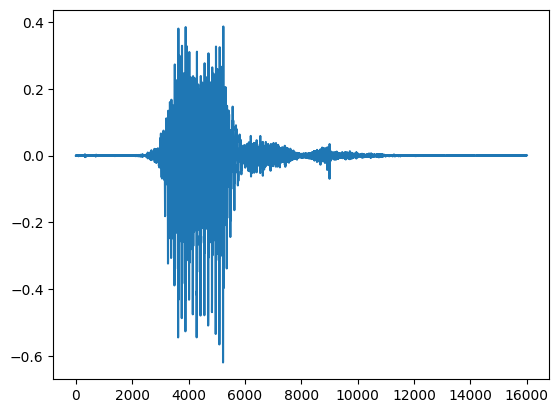

In [ ]:
import matplotlib.pyplot as plt
# plot the raw audio signal
tensor = tf.cast(raw_audio_tensor, tf.float32) / 32768.0
plt.figure()
plt.plot(tensor.numpy())

In [ ]:
# Trim the noise from the beginning and the end of the audio signal
position = tfio.audio.trim(tensor, axis=0, epsilon=0.05)
print(position)
start = position[0]
stop = position[1]
print(start, stop)
# getting a tensor object of the start and stop sample of the actual phrase (elimiating preceding and succeeding noise)

tf.Tensor([3001 6544], shape=(2,), dtype=int64)
tf.Tensor(3001, shape=(), dtype=int64) tf.Tensor(6544, shape=(), dtype=int64)


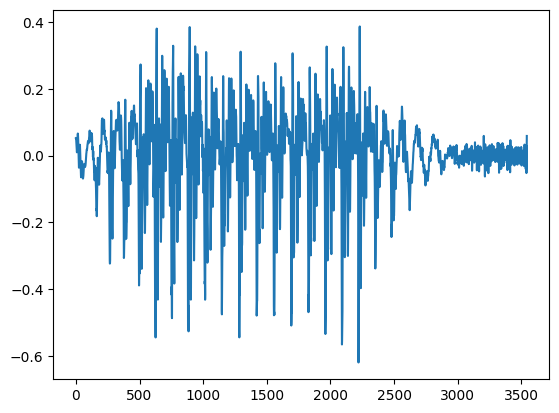

In [ ]:
processed = tensor[start:stop]
plt.figure()
plt.plot(processed.numpy())
# we can see that the singal was shifted the start from 0

In [ ]:
# play the original audio
print('Original audio')
Audio(tensor.numpy(), rate=SAMPLE_RATE)

Original audio


In [ ]:
# play the processed audio - no surrounding noise
print('Processed audio')
Audio(processed.numpy(), rate=SAMPLE_RATE)

Processed audio


More preprocessing

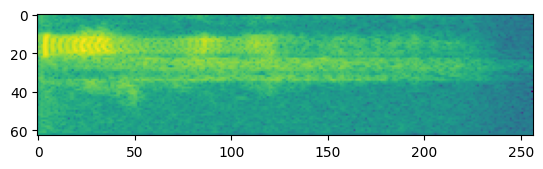

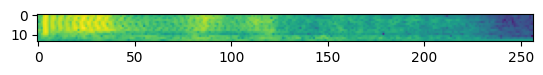

In [ ]:
# Convert to spectrogram - some sort of STFT being applied
original_spectrogram = tfio.audio.spectrogram(
    tensor, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(original_spectrogram).numpy())

processed_spectrogram = tfio.audio.spectrogram(processed, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(processed_spectrogram).numpy())

In [ ]:
# fill processed_audio with zeros
padded_processed_audio = tf.pad(processed, paddings=[[0, SAMPLE_RATE - tf.shape(processed)[0]]], mode='CONSTANT', constant_values=0)
Audio(padded_processed_audio.numpy(), rate=SAMPLE_RATE)

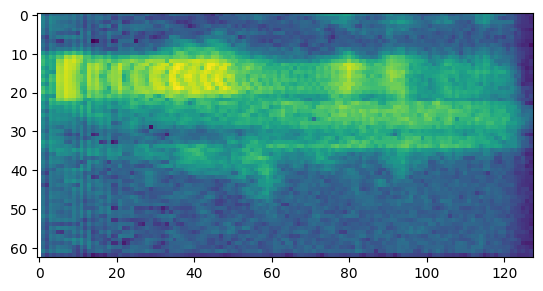

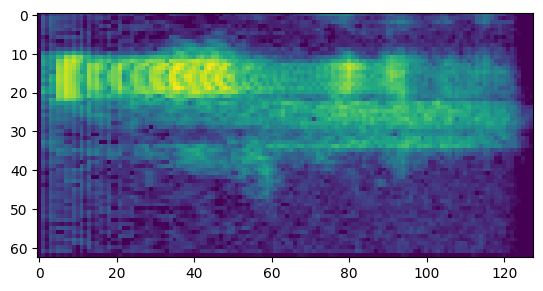

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    original_spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())